In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from wordcloud import WordCloud
from scipy.stats import f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [62]:
# Read csv
df = pd.read_csv('Styled Image And Neuron Attention Reseach Dataset.csv', encoding='ISO-8859-1')
df.head(10)

Image Name Category  No.1 Style  No.2 Style  \
0                        Image 1: Art Store   Retail           2           1   
1           Image 2: Cosmetics Retail Store   Retail           4           2   
2            Image 3: Clothing Retail Store   Retail           1           3   
3              Image 4: Flower and Art Shop   Retail           1           2   
4                Image 5: Dry Cleaner Store   Retail           4           2   
5                Image 6: Convenience Store   Retail           1           4   
6  Image 7: Retail Store Selling Fireplaces   Retail           4           2   
7           Image 8: Japanese Grocery Store   Retail           1           4   
8           Image 9: Furniture Retail Store   Retail           2           4   
9                   Image 10: Florist Store   Retail           2           1   

   No.3 Style  No.4 Style                                   Style 1 Keywords  \
0           3           4  Vivid contrast,Clear reflections,Hard-to-read ...   
1           3           1  Unnatural reflections,Cartoonish look,High con...   
2           2           4  Bright green sign,Window reflections,Color scheme   
3           3           4  Enhanced Door Image, Readable Sign, Visible Pe...   
4           1           3  Natural Contrast, Readable Phrases, Clear Refl...   
5           3           2  Blue-Black Contrast, Natural Feel, Dreamlike S...   
6           1           3  Hard to Read Sign, Unfitting Entrance, Exposed...   
7           2           3     Modern Feel, Well-Defined Carts, Simple Scheme   
8           1           3      Low Contrast, Unreadable Sign, Eccentric Look   
9           3           4  Sharp Reflections, Unreadable Text, Strong Col...   

                                    Style 2 Keywords  \
0    Attractive flowers,Bold sign,Excellent contrast   
1  Natural color scheme,Unclear person,Inaccurate...   
2    Darker tones,Unnatural contrast,Green and brown   
3     Soft Tones, Unnecessary Contrast, Relaxed Feel   
4  Classical Contrast, Unreadable Phrases, Striki...   
5   Too Much Black, Unreadable Sign, Unnatural Style   
6     Readable Phrases, Unique Colors, Good Contrast   
7  Dark Coloration, Unreadable Sign, Uneven Lighting   
8    Clear Contrast, Natural Lighting, Readable Text   
9  Accurate Reflections, Unique Texture, Bold Con...   

                                    Style 3 Keywords  \
0        Bright colors,Eccentric look,Illegible sign   
1  Dull appearance,Poor contrast,Indistinct refle...   
2    Purple sign,Sharper details,Brighter appearance   
3    Cartoonish Sketch, Aqua Sign, Unrealistic Style   
4      Low Contrast, Unclear Circles, Illegible Text   
5     Unfitting Colors, Cartoonish Sign, Bright Look   
6       Shadowed Image, Unnatural Colors, Bright Mix   
7  Over-Bright Colors, Unnatural Highlights, Inap...   
8         Colorful, Rainbow Scheme, Cartoonish Style   
9       Animated Feel, Hazy Backdrop, Rainbow Colors   

                                    Style 4 Keywords  ...  \
0  Dark colors,Unnatural flowers,Unwelcoming appe...  ...   
1  Natural color scheme,Human-like figure,Strong ...  ...   
2  Dark and gloomy,Blurred reflections,Unsettling...  ...   
3      Dull Scheme, Dark Frame, Hard to See Interior  ...   
4  Unfitting Colors, Sketchy Style, Inappropriate...  ...   
5  Transparent Windows, Clear Reflections, Striki...  ...   
6           Grand Appearance, Bold Sign, Dark Scheme  ...   
7         Relaxed Tone, Unfitting Font, Low Contrast  ...   
8        Strong Contrast, Natural Roof, Legible Text  ...   
9       Dark Mood, Low Brightness, Unappealing Style  ...   

   Style 3 Yellow Dot %  Style 3 Green Dot %  Style 4 Heatmap %  \
0                 3.558               12.929             23.558   
1                 4.607               15.360             36.496   
2                 1.971               18.449             36.341   
3                 4.316               16.527             44.983   
4                 4.493       

In [63]:
# Fill null with mean
df.fillna(df.mean(numeric_only=True), inplace=True)
# Check null value
missing_summary = df.isnull().sum()
print(missing_summary[missing_summary > 0])

Series([], dtype: int64)


In [64]:
# -------- New DataFrame for Style ranking record-------- 
# -------- Human Ranking --------
ranking_records = []

for idx, row in df.iterrows():
    image_name = row['Image Name']
    style_rank_map = {
        f'Style {row["No.1 Style"]}': 1,
        f'Style {row["No.2 Style"]}': 2,
        f'Style {row["No.3 Style"]}': 3,
        f'Style {row["No.4 Style"]}': 4,
    }
    for style, rank in style_rank_map.items():
        ranking_records.append({
            'Image Name': image_name,
            'Style': style,
            'Rank': rank,
            'Source': 'Prior'   # Label the source
        })

# -------- Neuron Ranking --------
for idx, row in df.iterrows():
    image_name = row['Image Name']
    style_rank_map = {
        f'Style {row["Neuron No.1 Style"]}': 1,
        f'Style {row["Neuron No.2 Style"]}': 2,
        f'Style {row["Neuron No.3 Style"]}': 3,
        f'Style {row["Neuron No.4 Style"]}': 4,
    }
    for style, rank in style_rank_map.items():
        ranking_records.append({
            'Image Name': image_name,
            'Style': style,
            'Rank': rank,
            'Source': 'Neuron'   # Label the source
        })

# -------- Create DataFrame --------
ranking_df = pd.DataFrame(ranking_records)

# Preview
ranking_df.head(10)


Image Name    Style  Rank Source
0               Image 1: Art Store  Style 2     1  Prior
1               Image 1: Art Store  Style 1     2  Prior
2               Image 1: Art Store  Style 3     3  Prior
3               Image 1: Art Store  Style 4     4  Prior
4  Image 2: Cosmetics Retail Store  Style 4     1  Prior
5  Image 2: Cosmetics Retail Store  Style 2     2  Prior
6  Image 2: Cosmetics Retail Store  Style 3     3  Prior
7  Image 2: Cosmetics Retail Store  Style 1     4  Prior
8   Image 3: Clothing Retail Store  Style 1     1  Prior
9   Image 3: Clothing Retail Store  Style 3     2  Prior

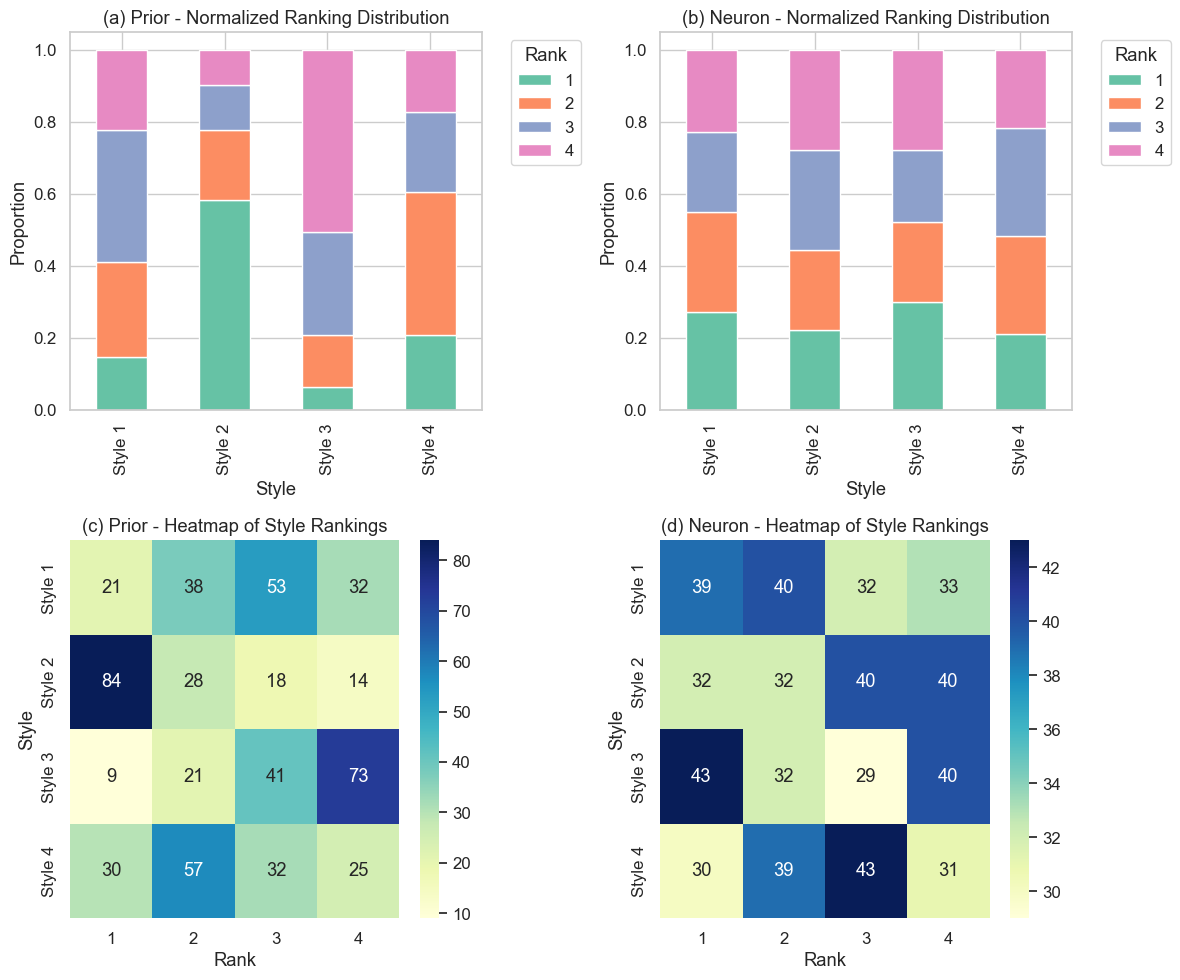

In [65]:
# -------- Visualize Style Ranking Distribution-------- 
# Prepare data
style_rank_count = ranking_df.groupby(['Source', 'Style', 'Rank']).size().reset_index(name='Count')

# Pivot for stacked bar and heatmap
pivot_df = style_rank_count.pivot_table(
    index=['Source', 'Style'], 
    columns='Rank', 
    values='Count',
    fill_value=0
)

# Normalize for proportion plot
norm_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)

# Define consistent color palette for ranks (4 ranks)
rank_palette = sns.color_palette("Set2", n_colors=4)
rank_labels = sorted(style_rank_count['Rank'].unique())

# Create figure with 3 columns (each column has 2 rows: Human & Neuron)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2行×2列
plt.subplots_adjust(hspace=0.4, wspace=0.3)

sources = ['Prior', 'Neuron']

for col_idx, source in enumerate(sources):  # 按列循环
    # Filter data
    data_source = style_rank_count[style_rank_count['Source'] == source]
    pivot_source = pivot_df.loc[source]
    norm_source = norm_df.loc[source]

    ## (a/b) Stacked barplot - normalized
    norm_source = norm_source[rank_labels]
    norm_source.plot(
        kind='bar',
        stacked=True,
        color=rank_palette,
        ax=axes[0, col_idx]
    )
    axes[0, col_idx].set_title(f'({chr(97 + col_idx)}) {source} - Normalized Ranking Distribution')
    axes[0, col_idx].set_ylabel('Proportion')
    axes[0, col_idx].set_xlabel('Style')
    axes[0, col_idx].legend(title='Rank', bbox_to_anchor=(1.05, 1), loc='upper left')

    ## (c/d) Heatmap - raw counts
    sns.heatmap(
        pivot_source,
        annot=True,
        cmap='YlGnBu',
        fmt='g',
        ax=axes[1, col_idx]
    )
    axes[1, col_idx].set_title(f'({chr(99 + col_idx)}) {source} - Heatmap of Style Rankings')
    axes[1, col_idx].set_xlabel('Rank')
    axes[1, col_idx].set_ylabel('Style')

plt.tight_layout()
plt.show()


In [66]:
#-------- Chi-squared test for each Rank separately-------- 
from scipy.stats import chi2_contingency

# Save results
chi2_results = []

# Perform test for each Rank separately
for rank in sorted(style_rank_count['Rank'].unique()):
    # Build a 2×4 contingency table for the current Rank
    table = (
        style_rank_count[style_rank_count['Rank'] == rank]
        .pivot(index='Source', columns='Style', values='Count')
        .fillna(0)
        .astype(int)
    )
    
    # Perform Chi-squared test
    chi2, p, dof, expected = chi2_contingency(table.values)

    # Print results
    print(f"Rank {rank}:")
    print(table)
    print(f"Chi-squared: {chi2:.3f}, df={dof}, p-value={p:.4f}")
    print("-" * 40)

    # Save results for this Rank
    chi2_results.append({
        'Rank': rank,
        'Chi2': chi2,
        'p-value': p,
        'df': dof
    })

# Summarize all results into a DataFrame
chi2_df = pd.DataFrame(chi2_results)


Rank 1:
Style   Style 1  Style 2  Style 3  Style 4
Source                                    
Neuron       39       32       43       30
Prior        21       84        9       30
Chi-squared: 50.941, df=3, p-value=0.0000
----------------------------------------
Rank 2:
Style   Style 1  Style 2  Style 3  Style 4
Source                                    
Neuron       40       32       32       39
Prior        38       28       21       57
Chi-squared: 5.973, df=3, p-value=0.1130
----------------------------------------
Rank 3:
Style   Style 1  Style 2  Style 3  Style 4
Source                                    
Neuron       32       40       29       43
Prior        53       18       41       32
Chi-squared: 17.204, df=3, p-value=0.0006
----------------------------------------
Rank 4:
Style   Style 1  Style 2  Style 3  Style 4
Source                                    
Neuron       33       40       40       31
Prior        32       14       73       25
Chi-squared: 22.814, df=3, p-val

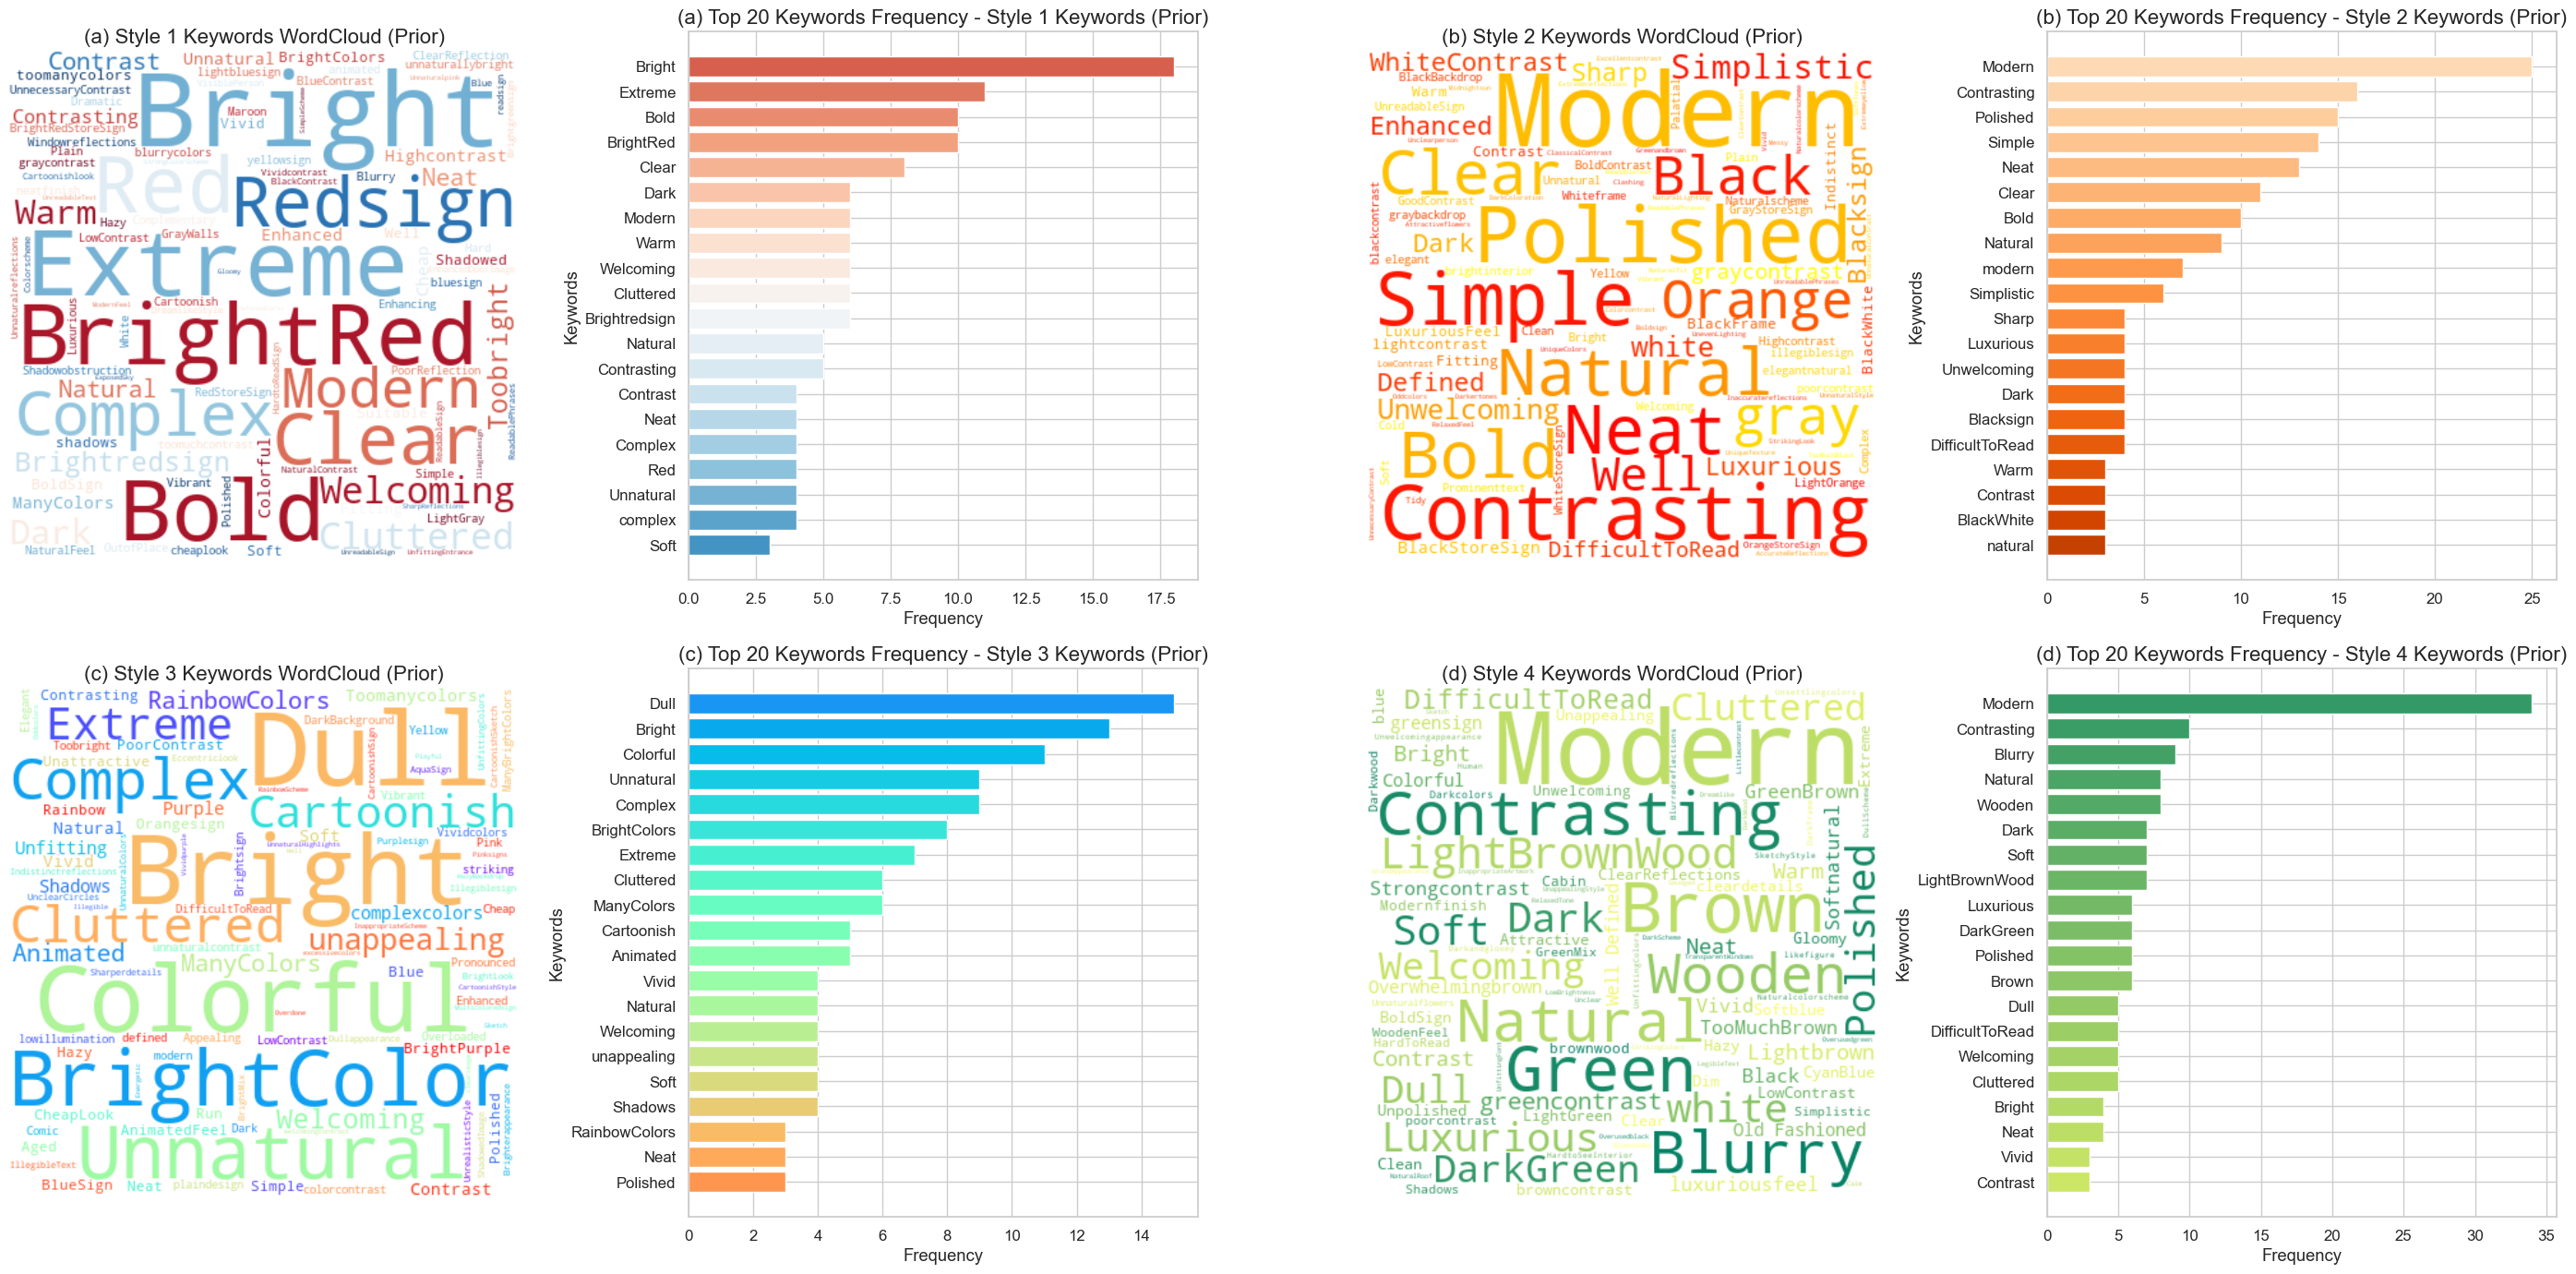

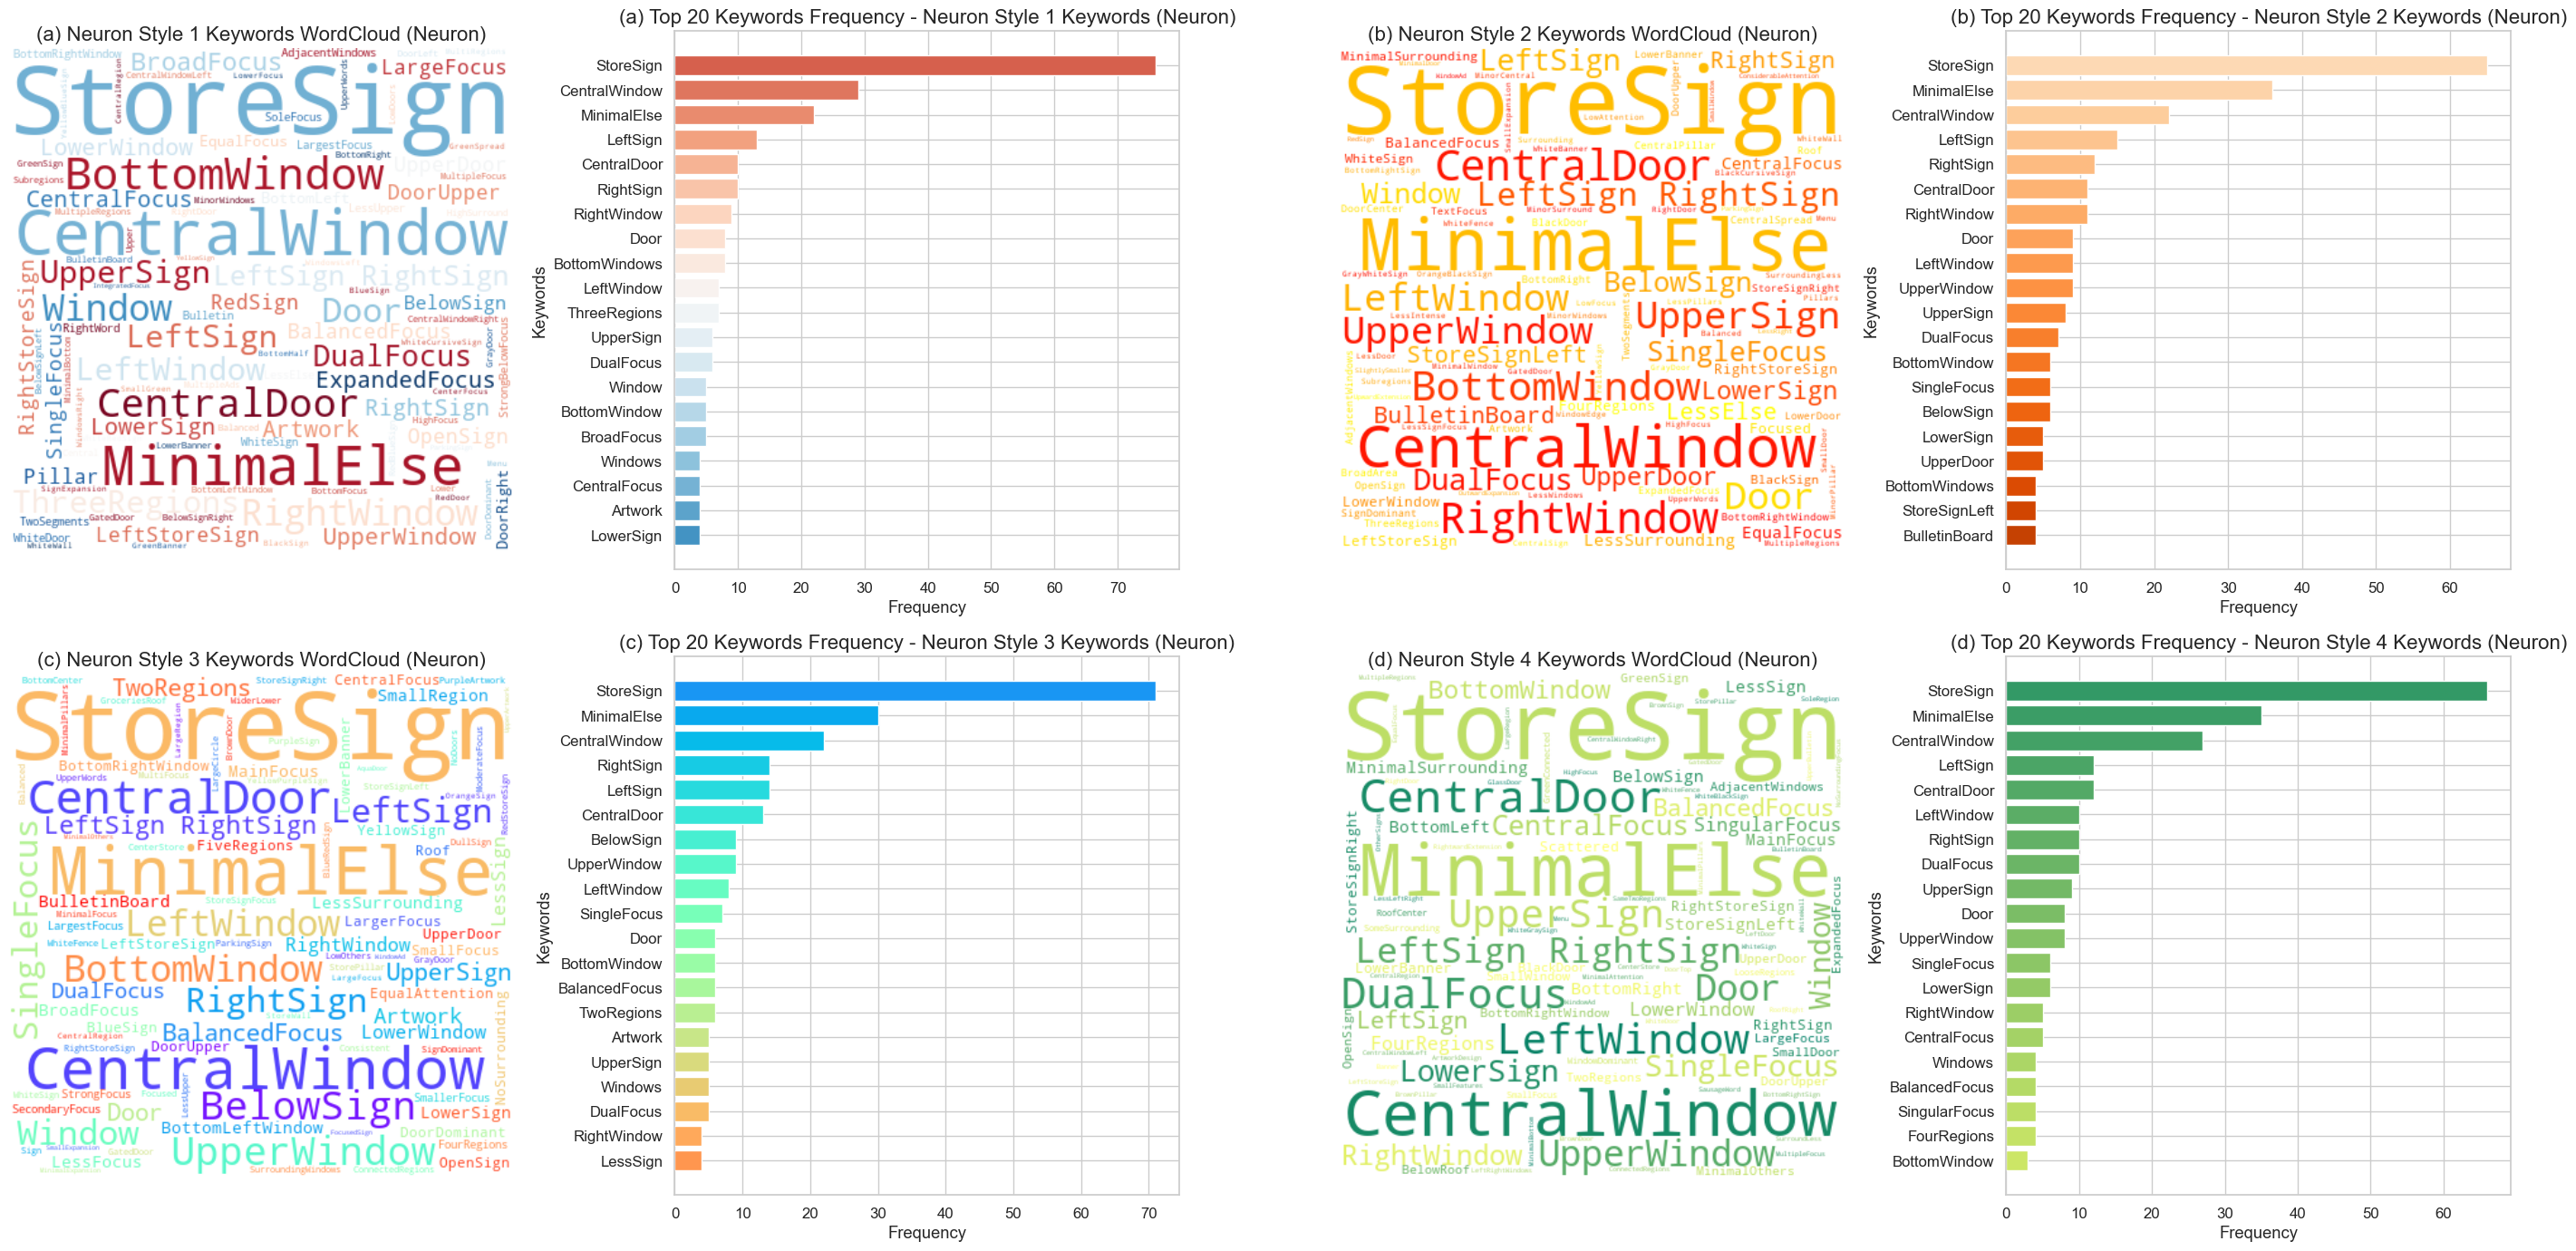

In [67]:
# --------  Keywords Wordcloud for Neuron and Prior -------- 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import matplotlib.cm as cm
import numpy as np

# ---------- Define keyword columns ----------
# Human
style_keywords_cols = ['Style 1 Keywords', 'Style 2 Keywords', 'Style 3 Keywords', 'Style 4 Keywords']
# Neuron
neuron_keywords_cols = ['Neuron Style 1 Keywords', 'Neuron Style 2 Keywords', 'Neuron Style 3 Keywords', 'Neuron Style 4 Keywords']

# ---------- Merge phrases function ----------
def merge_phrases(text):
    phrases = [p.strip() for p in text.split(',')]
    merged = [''.join(p.split()) for p in phrases]  # Remove spaces in phrases like "Vivid Contrast" → "VividContrast"
    return ' '.join(merged)

# ---------- Function to generate wordcloud + barchart ----------
def plot_keywords_wordcloud_barchart(keyword_cols, source_label):
    # Prepare texts
    style_texts = {}
    for col in keyword_cols:
        cleaned_keywords = df[col].dropna().astype(str).apply(merge_phrases)
        text = ' '.join(cleaned_keywords.values)
        style_texts[col] = text

    # Generate wordclouds
    colormap_dict_wc = {
        keyword_cols[0]: 'RdBu',
        keyword_cols[1]: 'autumn',
        keyword_cols[2]: 'rainbow',
        keyword_cols[3]: 'summer',
    }

    wordclouds = {}
    for col, text in style_texts.items():
        wordclouds[col] = WordCloud(
            width=400,
            height=400,
            background_color='white',
            colormap=colormap_dict_wc[col],
            max_words=100,
            max_font_size=80,
            random_state=42
        ).generate(text)

    # Top20 words for bar chart
    top_words = {}
    for col, text in style_texts.items():
        words = text.split()  
        counter = Counter(words)
        top_words[col] = counter.most_common(20)

    # Bar chart color maps
    colormap_dict_bar = {
        keyword_cols[0]: 'RdBu',
        keyword_cols[1]: 'Oranges',
        keyword_cols[2]: 'rainbow',
        keyword_cols[3]: 'summer',
    }

    # Plot: 2 rows × 4 columns
    fig, axes = plt.subplots(2, 4, figsize=(28, 14))
    axes = axes.reshape(-1, 2)  # Reshape to 4 pairs: [(0,0)-(0,1)], [(0,2)-(0,3)], ...
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, col in enumerate(keyword_cols):
        # WordCloud on the left
        ax_wc = axes[i][0]
        ax_wc.imshow(wordclouds[col], interpolation='bilinear')
        ax_wc.set_xlim(0, 400)
        ax_wc.set_ylim(400, 0)
        ax_wc.axis('off')
        ax_wc.set_title(f'({chr(97 + i)}) {col} WordCloud ({source_label})', fontsize=16)


        # Bar chart on the right
        ax_bar = axes[i][1]
        words, counts = zip(*top_words[col])
        cmap = cm.get_cmap(colormap_dict_bar[col])
        colors = [cmap(x) for x in np.linspace(0.2, 0.8, len(words))]
        ax_bar.barh(words[::-1], counts[::-1], color=colors[::-1])
        ax_bar.set_title(f'({chr(97 + i)}) Top 20 Keywords Frequency - {col} ({source_label})', fontsize=16)
        ax_bar.set_xlabel('Frequency')
        ax_bar.set_ylabel('Keywords')

    plt.tight_layout()
    plt.show()


# ---------- Plot for Human ----------
plot_keywords_wordcloud_barchart(style_keywords_cols, source_label='Prior')

# ---------- Plot for Neuron ----------
plot_keywords_wordcloud_barchart(neuron_keywords_cols, source_label='Neuron')


In [68]:
# --------  4 Neuron parameter check-------- 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import f_oneway
import warnings

warnings.filterwarnings("ignore")

param_cols = [
    'Origin Neuron Focus', 'Origin Neuron Cognitive Demand', 'Origin Neuron Engagement', 'Origin Neuron Memory',
    'Style 1 Neuron Focus', 'Style 1 Neuron Cognitive Demand', 'Style 1 Neuron Engagement', 'Style 1 Neuron Memory',
    'Style 2 Neuron Focus', 'Style 2 Neuron Cognitive Demand', 'Style 2 Neuron Engagement', 'Style 2 Neuron Memory',
    'Style 3 Neuron Focus', 'Style 3 Neuron Cognitive Demand', 'Style 3 Neuron Engagement', 'Style 3 Neuron Memory',
    'Style 4 Neuron Focus', 'Style 4 Neuron Cognitive Demand', 'Style 4 Neuron Engagement', 'Style 4 Neuron Memory'
]

df_params = df[['Image Name'] + param_cols]

long_df = pd.melt(
    df_params,
    id_vars=['Image Name'],
    value_vars=param_cols,
    var_name='Style_Parameter',
    value_name='Value'
)

#  extract Style Parameter
long_df[['Style', 'Parameter']] = long_df['Style_Parameter'].str.extract(r'(Origin|Style \d) Neuron (.*)')
long_df.drop(columns='Style_Parameter', inplace=True)


In [69]:
# One Way Anova
for param in long_df['Parameter'].unique():
    values = [long_df[(long_df['Parameter'] == param) & (long_df['Style'] == style)]['Value'].dropna()
              for style in ['Origin','Style 1', 'Style 2', 'Style 3', 'Style 4']]
    stat, p = f_oneway(*values)
    print(f'{param}: F = {stat:.3f}, p = {p:.4f}')


Focus: F = 3.825, p = 0.0044
Cognitive Demand: F = 36.342, p = 0.0000
Engagement: F = 9.715, p = 0.0000
Memory: F = 16.365, p = 0.0000


In [70]:
def analyze_and_plot(param, df):
    """
    Perform ANOVA and Tukey HSD test for a given parameter,
    and plot boxplots with significant pairwise differences marked.
    Includes 'Origin' and all styles.
    """
    # Filter the data for the specified parameter
    data = df[df['Parameter'] == param].copy()
    
    # Prepare ANOVA groups, including 'Origin'
    groups = [data[data['Style'] == s]['Value'].dropna() for s in sorted(data['Style'].unique())]
    stat, p = f_oneway(*groups)
    print(f"\n=== ANOVA for {param} (Including Origin) ===")
    print(f"F = {stat:.3f}, p = {p:.4f}")
    
    # Perform Tukey HSD test
    tukey = pairwise_tukeyhsd(endog=data['Value'], groups=data['Style'], alpha=0.05)
    print(tukey.summary())
    
    # Extract significantly different pairs from Tukey results
    sig_pairs = []
    summary_data = tukey._results_table.data
    for row in summary_data[1:]:
        group1, group2, reject = row[0], row[1], row[6]
        if reject:
            sig_pairs.append((group1, group2))
    
    # Plotting
    plt.figure(figsize=(8,6))
    ax = sns.boxplot(x='Style', y='Value', data=data, palette='Set2')
    sns.swarmplot(x='Style', y='Value', data=data, color='k', alpha=0.6, size=3)
    
    # Add significance lines and asterisks for significant pairs
    ymax = 100   # maximum y-axis value (you can adjust this if needed)
    y_offset = ymax * 0.05
    for idx, (s1, s2) in enumerate(sig_pairs):
        # Convert style name to position; put 'Origin' on the far left (x=0)
        def get_pos(s):
            if s == 'Origin':
                return 0
            else:
                return int(s.split()[-1])
        x1, x2 = sorted([get_pos(s1), get_pos(s2)])
        y = ymax + y_offset * (idx+1)
        plt.plot([x1, x1, x2, x2], [y, y+y_offset/2, y+y_offset/2, y], lw=1.5, c='k')
        plt.text((x1+x2)/2, y+y_offset/2, '*', ha='center', va='bottom', color='k', fontsize=14)
    
    plt.title(f'{param} Across Styles (Including Origin)\n(ANOVA p = {p:.4f})')
    plt.tight_layout()
    plt.show()



=== ANOVA for Focus (Including Origin) ===
F = 3.825, p = 0.0044
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
 Origin Style 1   3.8125 0.1105 -0.4918  8.1168  False
 Origin Style 2   5.8403 0.0021   1.536 10.1446   True
 Origin Style 3   2.4236 0.5368 -1.8807  6.7279  False
 Origin Style 4   4.0764 0.0733 -0.2279  8.3807  False
Style 1 Style 2   2.0278 0.6985 -2.2765  6.3321  False
Style 1 Style 3  -1.3889 0.9034 -5.6932  2.9154  False
Style 1 Style 4   0.2639 0.9998 -4.0404  4.5682  False
Style 2 Style 3  -3.4167  0.192  -7.721  0.8877  False
Style 2 Style 4  -1.7639 0.7956 -6.0682  2.5404  False
Style 3 Style 4   1.6528 0.8318 -2.6515  5.9571  False
------------------------------------------------------


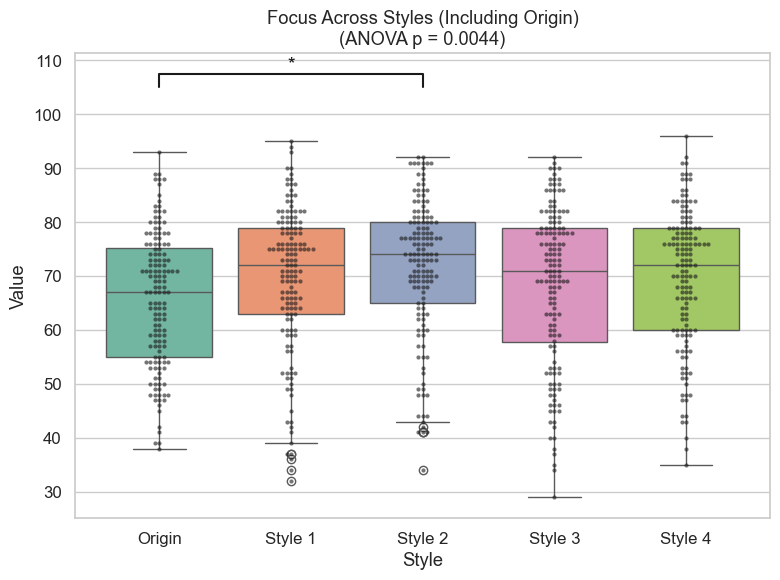

In [71]:
analyze_and_plot('Focus', long_df)


=== ANOVA for Cognitive Demand (Including Origin) ===
F = 36.342, p = 0.0000
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower    upper  reject
-------------------------------------------------------
 Origin Style 1  -6.8472    0.0  -9.4467 -4.2477   True
 Origin Style 2  -7.6597    0.0 -10.2592 -5.0602   True
 Origin Style 3  -9.9028    0.0 -12.5023 -7.3033   True
 Origin Style 4  -9.8125    0.0  -12.412  -7.213   True
Style 1 Style 2  -0.8125 0.9131   -3.412   1.787  False
Style 1 Style 3  -3.0556 0.0119  -5.6551  -0.456   True
Style 1 Style 4  -2.9653 0.0161  -5.5648 -0.3658   True
Style 2 Style 3  -2.2431 0.1277  -4.8426  0.3565  False
Style 2 Style 4  -2.1528 0.1577  -4.7523  0.4467  False
Style 3 Style 4   0.0903    1.0  -2.5092  2.6898  False
-------------------------------------------------------


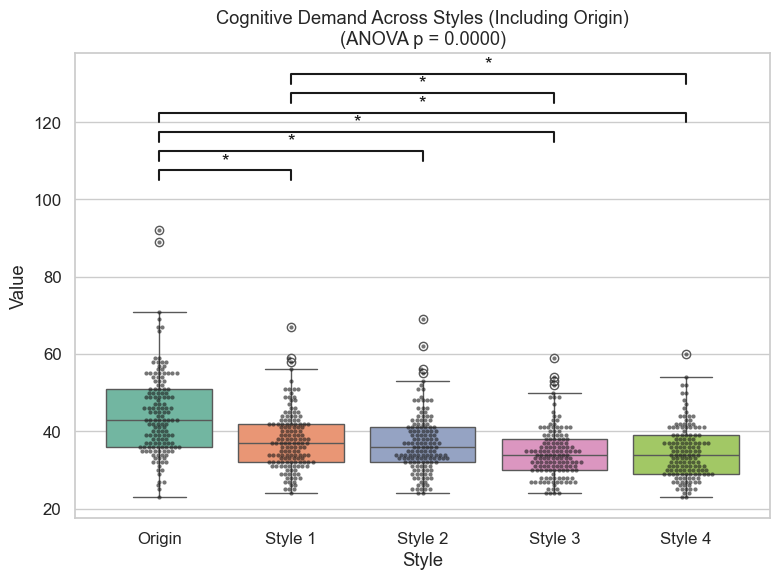

In [72]:
analyze_and_plot('Cognitive Demand', long_df)


=== ANOVA for Engagement (Including Origin) ===
F = 9.715, p = 0.0000
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
 Origin Style 1  -3.4375 0.0248 -6.5924 -0.2826   True
 Origin Style 2  -5.6181    0.0 -8.7729 -2.4632   True
 Origin Style 3  -3.0764   0.06 -6.2312  0.0785  False
 Origin Style 4  -6.5347    0.0 -9.6896 -3.3799   True
Style 1 Style 2  -2.1806 0.3235 -5.3354  0.9743  False
Style 1 Style 3   0.3611 0.9979 -2.7937   3.516  False
Style 1 Style 4  -3.0972 0.0572 -6.2521  0.0576  False
Style 2 Style 3   2.5417 0.1796 -0.6132  5.6965  False
Style 2 Style 4  -0.9167 0.9322 -4.0715  2.2382  False
Style 3 Style 4  -3.4583 0.0235 -6.6132 -0.3035   True
------------------------------------------------------


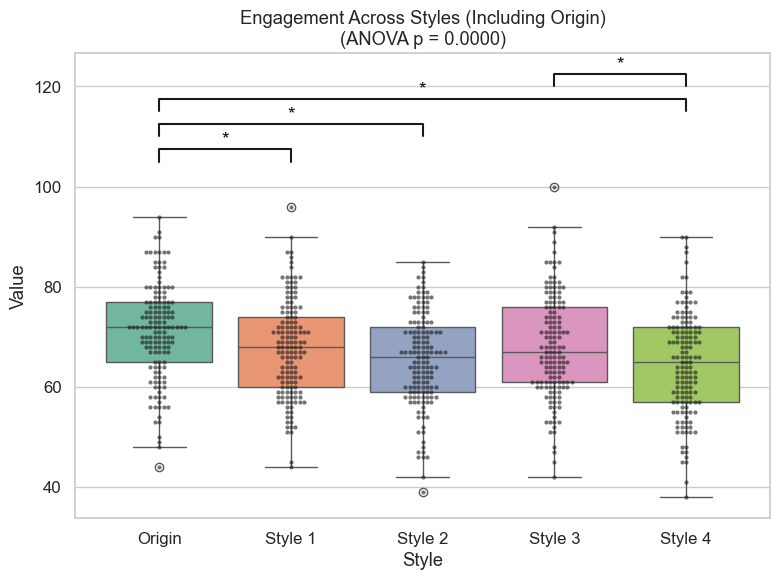

In [73]:
analyze_and_plot('Engagement', long_df)


=== ANOVA for Memory (Including Origin) ===
F = 16.365, p = 0.0000
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower    upper  reject
-------------------------------------------------------
 Origin Style 1  -4.3472 0.0048  -7.7624 -0.9321   True
 Origin Style 2  -8.2361    0.0 -11.6512  -4.821   True
 Origin Style 3  -8.6806    0.0 -12.0957 -5.2654   True
 Origin Style 4  -6.8958    0.0  -10.311 -3.4807   True
Style 1 Style 2  -3.8889 0.0164   -7.304 -0.4738   True
Style 1 Style 3  -4.3333  0.005  -7.7485 -0.9182   True
Style 1 Style 4  -2.5486 0.2476  -5.9637  0.8665  False
Style 2 Style 3  -0.4444 0.9966  -3.8596  2.9707  False
Style 2 Style 4   1.3403 0.8203  -2.0749  4.7554  False
Style 3 Style 4   1.7847  0.609  -1.6304  5.1999  False
-------------------------------------------------------


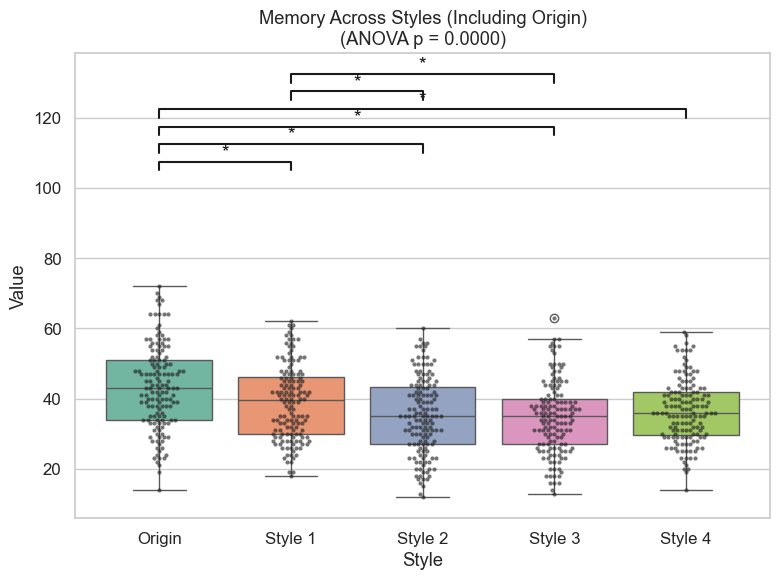

In [74]:
analyze_and_plot('Memory', long_df)

In [75]:
# ------------------------ Data Preparation For Neuron Heatmap And Color Dot ------------------------

# 1. long_df_box: Boxplot data for Heatmap % by Category and Type
heatmap_cols = ['Style 1 Heatmap %', 'Style 2 Heatmap %', 'Style 3 Heatmap %', 'Style 4 Heatmap %', 'Original Heatmap %']
long_df_box = df.melt(id_vars=['Category'], value_vars=heatmap_cols,
                      var_name='Heatmap Type', value_name='Heatmap %')

# 2. long_df_line: Lineplot data for Heatmap % by Rank and Style
rows = []
for i in range(1, 5):
    rank_col = f'No.{i} Style'
    heatmap_col = f'Style {i} Heatmap %'
    temp_df = df[[rank_col, heatmap_col]].copy()
    temp_df.columns = ['Style', 'Heatmap %']
    temp_df['Rank'] = i
    rows.append(temp_df)
long_df_line = pd.concat(rows, ignore_index=True)

# 3. df_dots_long: Long format data for Dot Color % (including all Styles and colors)
color_names = ['Red', 'Yellow', 'Green']
styles = ['Style 1', 'Style 2', 'Style 3', 'Style 4', 'Original']

color_dfs = []
for color in color_names:
    cols = [f'{style} {color} Dot %' for style in styles]
    temp = df[cols].copy()
    temp.columns = styles
    temp_long = temp.melt(var_name='Style', value_name='Dot %')
    temp_long['Color'] = color
    color_dfs.append(temp_long)

df_dots_long = pd.concat(color_dfs, ignore_index=True)

# 4. df_heatmap_long: Long format data for overall Heatmap %
heatmap_cols = [f'{style} Heatmap %' for style in styles]
df_heatmap_long = df[heatmap_cols].copy()
df_heatmap_long.columns = styles
df_heatmap_long = df_heatmap_long.melt(var_name='Style', value_name='Heatmap %')

# 5. df_combined: Combined data for Dot Color and overall Heatmap % for boxplots
df_dots_long_full = df_dots_long.rename(columns={'Dot %': 'Value', 'Color': 'Measure'})

color_map = {
    'Red': 'Red Area',
    'Yellow': 'Yellow Area',
    'Green': 'Green Area'
}
df_dots_long_full['Measure'] = df_dots_long_full['Measure'].map(color_map)

df_heatmap_long_full = df_heatmap_long.rename(columns={'Heatmap %': 'Value'})
df_heatmap_long_full['Measure'] = 'Whole heatmap'

df_combined = pd.concat([
    df_dots_long_full[['Style', 'Measure', 'Value']],
    df_heatmap_long_full[['Style', 'Measure', 'Value']]
], ignore_index=True)


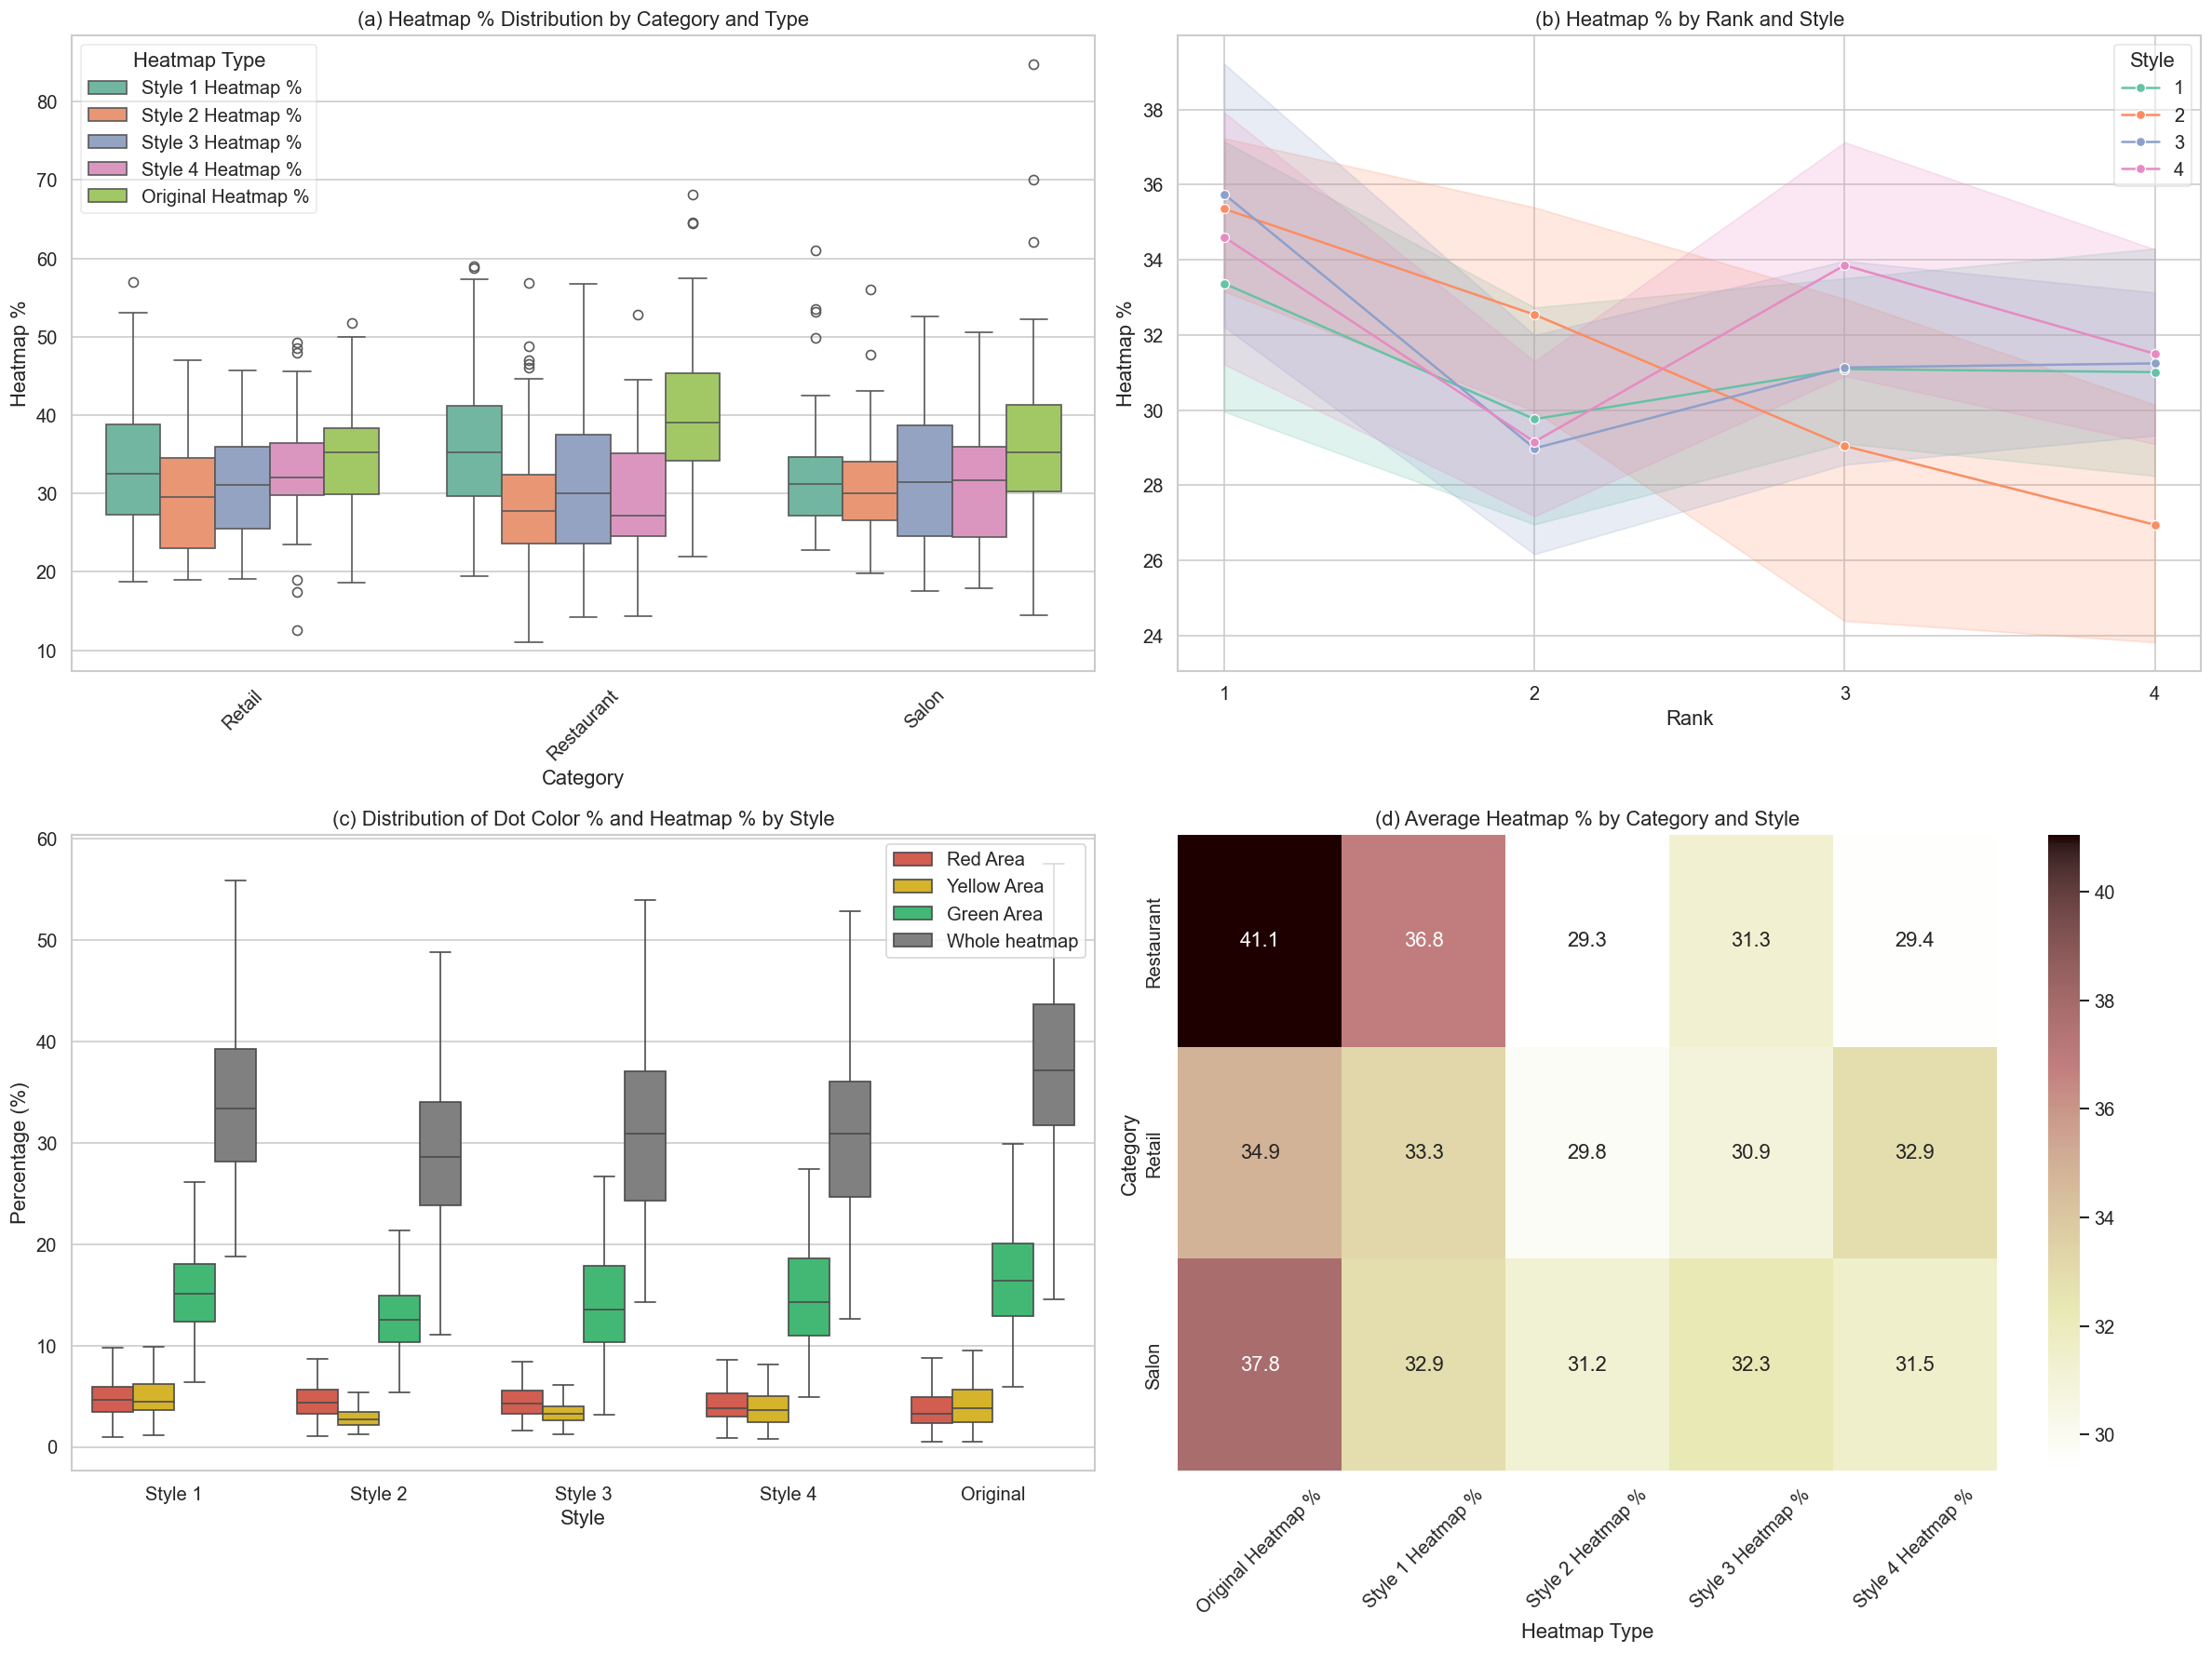

In [76]:
# ------------------------ Neuron Heatmap And Color Dot EDA Plot ------------------------

sns.set(style='whitegrid', font_scale=1.1)
fig, axes = plt.subplots(2, 2, figsize=(20, 15), dpi=120)

# (a) Heatmap % Distribution by Category and Type (boxplot)
sns.boxplot(data=long_df_box, x='Category', y='Heatmap %',
            hue='Heatmap Type', palette='Set2', ax=axes[0, 0])
axes[0, 0].set_title('(a) Heatmap % Distribution by Category and Type')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].legend(title='Heatmap Type', loc='upper left', frameon=True, framealpha=0.4)

# (b) Heatmap % by Rank and Style (lineplot)
sns.lineplot(data=long_df_line, x='Rank', y='Heatmap %',
             hue='Style', palette='Set2', marker='o', ax=axes[0, 1])
axes[0, 1].set_title('(b) Heatmap % by Rank and Style')
axes[0, 1].xaxis.set_major_locator(ticker.FixedLocator([1, 2, 3, 4]))
axes[0, 1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
axes[0, 1].legend(title='Style', loc='upper right', framealpha=0.5)

# (c) Dot Color % and Heatmap % by Style (boxplot)
sns.boxplot(data=df_combined, x='Style', y='Value', hue='Measure',
            palette=['#E74C3C', '#F1C40F', '#2ECC71', 'gray'],
            showfliers=False, ax=axes[1, 0])
axes[1, 0].set_title('(c) Distribution of Dot Color % and Heatmap % by Style')
axes[1, 0].set_ylabel('Percentage (%)')
axes[1, 0].legend(title='', loc='upper right')

# (d) Heatmap: Average Heatmap % by Category and Heatmap Type
pivot_df = long_df_box.groupby(['Category', 'Heatmap Type'])['Heatmap %'].mean().unstack()

sns.heatmap(pivot_df, annot=True, fmt=".1f", cmap=sns.color_palette("pink_r", as_cmap=True), ax=axes[1, 1])
axes[1, 1].set_title('(d) Average Heatmap % by Category and Style')
axes[1, 1].set_xlabel('Heatmap Type')
axes[1, 1].set_ylabel('Category')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [77]:
# ------------------------  Anova And Post-hoc Pairwise Comparisons ------------------------ 

anova_results = []
tukey_results = []

for color in df_dots_long['Color'].unique():
    df_color = df_dots_long[df_dots_long['Color'] == color]

    try:
        # ANOVA
        model = smf.ols('Q("Dot %") ~ C(Style)', data=df_color).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)

        f_value = anova_table.loc['C(Style)', 'F']
        p_value = anova_table.loc['C(Style)', 'PR(>F)']

        anova_results.append({
            'Color': color,
            'F-value': round(f_value, 3),
            'p-value': round(p_value, 5),
            'Significant': '✅ Yes' if p_value < 0.05 else '❌ No'
        })

        # if ANOVA significant，applied Tukey HSD
        if p_value < 0.05:
            tukey = pairwise_tukeyhsd(endog=df_color['Dot %'],
                                      groups=df_color['Style'],
                                      alpha=0.05)
            tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
            tukey_df['Color'] = color
            tukey_results.append(tukey_df)

    except Exception as e:
        anova_results.append({
            'Color': color,
            'F-value': None,
            'p-value': None,
            'Significant': f'Error: {e}'
        })

anova_df = pd.DataFrame(anova_results)
print("ANOVA Summary:")
display(anova_df)

if tukey_results:
    tukey_all = pd.concat(tukey_results, ignore_index=True)
    print("\nTukey HSD post-hoc test results (only significant ANOVA colors):")
    display(tukey_all)
else:
    print("\nNo significant ANOVA results, so no Tukey HSD post-hoc tests performed.")


ANOVA Summary:


Color  F-value  p-value Significant
0     Red    6.472  0.00004       ✅ Yes
1  Yellow   31.376  0.00000       ✅ Yes
2   Green   13.994  0.00000       ✅ Yes


Tukey HSD post-hoc test results (only significant ANOVA colors):


group1   group2  meandiff   p-adj   lower   upper  reject   Color
0   Original  Style 1    1.0251  0.0001  0.4067  1.6435    True     Red
1   Original  Style 2    0.9138  0.0006  0.2954  1.5322    True     Red
2   Original  Style 3    0.7718  0.0061  0.1534  1.3902    True     Red
3   Original  Style 4    0.5305  0.1318 -0.0879  1.1489   False     Red
4    Style 1  Style 2   -0.1113  0.9881 -0.7297  0.5071   False     Red
5    Style 1  Style 3   -0.2533  0.7960 -0.8717  0.3651   False     Red
6    Style 1  Style 4   -0.4946  0.1857 -1.1130  0.1238   False     Red
7    Style 2  Style 3   -0.1420  0.9706 -0.7604  0.4764   False     Red
8    Style 2  Style 4   -0.3833  0.4376 -1.0017  0.2351   False     Red
9    Style 3  Style 4   -0.2413  0.8233 -0.8597  0.3771   False     Red
10  Original  Style 1    0.6988  0.0065  0.1358  1.2617    True  Yellow
11  Original  Style 2   -1.4169  0.0000 -1.9798 -0.8539    True  Yellow
12  Original  Style 3   -0.9043  0.0001 -1.4673 -0.3413    True  Yellow
13  Original  Style 4   -0.4755  0.1429 -1.0385  0.0875   False  Yellow
14   Style 1  Style 2   -2.1156  0.0000 -2.6786 -1.5526    True  Yellow
15   Style 1  Style 3   -1.6031  0.0000 -2.1661 -1.0401    True  Yellow
16   Style 1  Style 4   -1.1743  0.0000 -1.7372 -0.6113    True  Yellow
17   Style 2  Style 3    0.5125  0.0941 -0.0505  1.0755   False  Yellow
18   Style 2  Style 4    0.9414  0.0001  0.3784  1.5043    True  Yellow
19   Style 3  Style 4    0.4288  0.2285 -0.1342  0.9918   False  Yellow
20  Original  Style 1   -0.9804  0.4032 -2.5112  0.5505   False   Green
21  Original  Style 2   -3.8545  0.0000 -5.3854 -2.3237    True   Green
22  Original  Style 3   -2.5412  0.0001 -4.0720 -1.0103    True   Green
23  Original  Style 4   -2.1899  0.0009 -3.7207 -0.6590    True   Green
24   Style 1  Style 2   -2.8742  0.0000 -4.4050 -1.3433    True   Green
25   Style 1  Style 3   -1.5608  0.0431 -3.0916 -0.0300    True   Green
26   Style 1  Style 4   -1.2095  0.1960 -2.7403  0.3213   False   Green
27   Style 2  Style 3    1.3134  0.1317 -0.2175  2.8442   False   Green
28   Style 2  Style 4    1.6647  0.0252  0.1338  3.1955    True   Green
29   Style 3  Style 4    0.3513  0.9706 -1.1795  1.8821   False   Green